## Transformer for time series forecasting
- https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-4.transformer-post/
- https://github.com/Doheon/TimeSeriesForecast-Transformer/tree/main

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.10.25</div>
<div style="text-align: right"> Last update: 2023.10.25</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

### Load data

In [2]:
raw = pd.read_csv('../data/highway.csv', encoding='CP949')
raw = raw.iloc[:, 1:]

In [3]:
raw.head()

,집계일시,평균속도
0,2021050100,98.63
1,2021050101,100.53
2,2021050102,99.86
3,2021050103,99.34
4,2021050104,93.64


In [4]:
raw['집계일시'] = raw['집계일시'].apply(lambda x: pd.to_datetime(str(x)[:8] + ' ' + str(x)[8:10] + ':00:00'))

In [5]:
raw.head()

,집계일시,평균속도
0,2021-05-01 00:00:00,98.63
1,2021-05-01 01:00:00,100.53
2,2021-05-01 02:00:00,99.86
3,2021-05-01 03:00:00,99.34
4,2021-05-01 04:00:00,93.64


<Axes: xlabel='집계일시'>

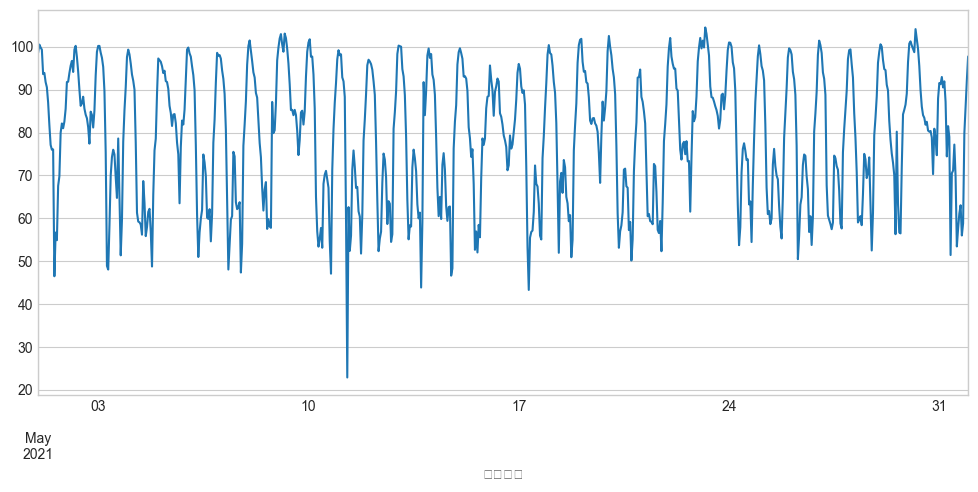

In [6]:
fig, ax = plt.subplots(figsize = (12, 5))
raw.set_index('집계일시')['평균속도'].plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
raw["평균속도"] = min_max_scaler.fit_transform(raw["평균속도"].to_numpy().reshape(-1,1))

In [8]:
raw.head()

,집계일시,평균속도
0,2021-05-01 00:00:00,0.927845
1,2021-05-01 01:00:00,0.951121
2,2021-05-01 02:00:00,0.942913
3,2021-05-01 03:00:00,0.936543
4,2021-05-01 04:00:00,0.866716


마지막 일주일을 테스트 데이터로 분리

In [9]:
train = raw[:-24*7]
data_train = train["평균속도"].to_numpy()

test = raw[-24*7:]
data_test = test["평균속도"].to_numpy()

In [10]:
data_train

array([0.92784515, 0.95112091, 0.94291314, 0.93654294, 0.86671567,
       0.87014578, 0.84392993, 0.82910695, 0.78574054, 0.72105843,
       0.6644616 , 0.65074115, 0.65172118, 0.2892319 , 0.41406346,
       0.39225775, 0.54734779, 0.57491118, 0.69937523, 0.72583609,
       0.71211564, 0.73122626, 0.76760995, 0.84417494, 0.84503246,
       0.86990077, 0.89084895, 0.9045694 , 0.87296337, 0.93678795,
       0.9475683 , 0.91571726, 0.87418841, 0.82224672, 0.77618523,
       0.78304545, 0.80215607, 0.76822247, 0.7508269 , 0.74065907,
       0.71505574, 0.66813671, 0.75952468, 0.75009188, 0.71419821,
       0.76270979, 0.86304055, 0.93041774, 0.94732329, 0.94732329,
       0.92809016, 0.91338969, 0.88729634, 0.81808159, 0.64290089,
       0.31875536, 0.30834252, 0.43366409, 0.57723876, 0.62991547,
       0.65074115, 0.63726571, 0.57209359, 0.51304667, 0.68283719,
       0.50863653, 0.34901384, 0.45130467, 0.6737719 , 0.76381232,
       0.82922945, 0.91559476, 0.93678795, 0.9230675 , 0.89721

### Transformer Encoder, Decoder

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class windowDataset(Dataset):
    def __init__(self, y, input_window = 80, output_window = 20, stride = 5):
        #총 데이터 개수
        L = y.shape[0]
        
        # stride를 움직일 때 생기는 총 sample의 수
        num_samples = (L - input_window - output_window) // stride + 1
        
        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])
        
        for i in np.arange(num_samples):
            start_x = stride * i
            end_x = start_x + input_window
            X[:, i] = y[start_x : end_x]
            
            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            
            
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:] #input, decoder input(마지막 값을 제외한것), output(첫번째값을 제외한것)
    def __len__(self):
        return self.len

In [13]:
iw = 80
ow = 20
stride = 1

In [14]:

L = data_train.shape[0]
L

576

In [15]:
num_samples = (L - iw - ow)// stride + 1
num_samples

477

In [16]:
X = np.zeros([iw, num_samples])
Y = np.zeros([ow, num_samples])
print(X.shape)
print(Y.shape)

(80, 477)
(20, 477)


In [17]:
for i in np.arange(num_samples):
    start_x = stride * i
    end_x = start_x + iw
    X[:, i] = data_train[start_x : end_x]
            
    start_y = stride*i + iw
    end_y = start_y + ow
    Y[:,i] = data_train[start_y:end_y]

In [18]:
X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2)).shape

(477, 80, 1)

In [19]:
Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2)).shape

(477, 20, 1)

In [20]:
X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))

In [21]:
data_train

array([0.92784515, 0.95112091, 0.94291314, 0.93654294, 0.86671567,
       0.87014578, 0.84392993, 0.82910695, 0.78574054, 0.72105843,
       0.6644616 , 0.65074115, 0.65172118, 0.2892319 , 0.41406346,
       0.39225775, 0.54734779, 0.57491118, 0.69937523, 0.72583609,
       0.71211564, 0.73122626, 0.76760995, 0.84417494, 0.84503246,
       0.86990077, 0.89084895, 0.9045694 , 0.87296337, 0.93678795,
       0.9475683 , 0.91571726, 0.87418841, 0.82224672, 0.77618523,
       0.78304545, 0.80215607, 0.76822247, 0.7508269 , 0.74065907,
       0.71505574, 0.66813671, 0.75952468, 0.75009188, 0.71419821,
       0.76270979, 0.86304055, 0.93041774, 0.94732329, 0.94732329,
       0.92809016, 0.91338969, 0.88729634, 0.81808159, 0.64290089,
       0.31875536, 0.30834252, 0.43366409, 0.57723876, 0.62991547,
       0.65074115, 0.63726571, 0.57209359, 0.51304667, 0.68283719,
       0.50863653, 0.34901384, 0.45130467, 0.6737719 , 0.76381232,
       0.82922945, 0.91559476, 0.93678795, 0.9230675 , 0.89721

In [22]:
X[0]

array([[0.92784515],
       [0.95112091],
       [0.94291314],
       [0.93654294],
       [0.86671567],
       [0.87014578],
       [0.84392993],
       [0.82910695],
       [0.78574054],
       [0.72105843],
       [0.6644616 ],
       [0.65074115],
       [0.65172118],
       [0.2892319 ],
       [0.41406346],
       [0.39225775],
       [0.54734779],
       [0.57491118],
       [0.69937523],
       [0.72583609],
       [0.71211564],
       [0.73122626],
       [0.76760995],
       [0.84417494],
       [0.84503246],
       [0.86990077],
       [0.89084895],
       [0.9045694 ],
       [0.87296337],
       [0.93678795],
       [0.9475683 ],
       [0.91571726],
       [0.87418841],
       [0.82224672],
       [0.77618523],
       [0.78304545],
       [0.80215607],
       [0.76822247],
       [0.7508269 ],
       [0.74065907],
       [0.71505574],
       [0.66813671],
       [0.75952468],
       [0.75009188],
       [0.71419821],
       [0.76270979],
       [0.86304055],
       [0.930

In [23]:
len(X)

477

In [24]:
Y[0, :-1]

array([[0.44542448],
       [0.44334191],
       [0.4368492 ],
       [0.40806076],
       [0.56119074],
       [0.49895872],
       [0.40389563],
       [0.42998897],
       [0.47311038],
       [0.48193066],
       [0.41651354],
       [0.3170403 ],
       [0.52284699],
       [0.64865858],
       [0.68222467],
       [0.81097636],
       [0.91142962],
       [0.90677447],
       [0.90199681]])

In [25]:
len(Y[0, :-1])

19

In [26]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [27]:
train_dataset.x.shape

(73, 336, 1)

In [28]:
train_dataset.y.shape

(73, 168, 1)

In [33]:
from torch.nn import Transformer
from torch import nn
import torch
import math

In [34]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [35]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, dropout = 0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(
            d_model = d_model, # 인코더 디코더 입력의 피처 수(default 512)
            nhead = nhead, # 멀티헤드 어텐션의 헤드수 (default 8)
            dim_feedforward=nhid, # 피드포워드 네트워크의 차원 (default 2048)
            num_encoder_layers=nlayers, #서브 인코더 레이어 수 (default 6)
            num_decoder_layers=nlayers, # 서브 디코더 레이어수 (default 6)
            dropout=dropout
            )
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(
            in_features=d_model,
            out_features=1
        )
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)
        
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output
        
        

In [36]:
a = [0, 0, 2, 3, 1, 0]

torch.eq(torch.Tensor(a), 0)

tensor([ True,  True, False, False, False,  True])

In [37]:
def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

- 데이터가 univariate time series이므로 input과 output의 차원은 모두 1차원이다.

- 인풋 데이터인 1차원의 벡터를 d_model의 차원으로 linear layer를 통해 바꿔준 후 positional encoding을 거쳐서 transformer를 통과하게 만들었다. 결과의 차원을 다시 1차원으로 만들어서 최종 output이 나오도록 했다.

- 자연어 처리때와는 달리 패딩없이 모든 데이터가 값을 가지고 있으므로 padding mask는 생략했다.

### Training

In [38]:
torch.backends.mps.is_available()

True

In [39]:
device = torch.device('mps')

In [40]:
lr = 1e-3
model = TFModel(
    d_model=256, 
    nhead=8, 
    nhid=256, 
    nlayers=2, 
    dropout=0.1
    ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [41]:
model

TFModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
      

In [42]:
epoch = 2000

from tqdm import tqdm

In [43]:
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00444: 100%|██████████| 2000/2000 [10:37<00:00,  3.14it/s]


### Evaluate

In [48]:
data_train.reshape(1, -1, 1).shape

(1, 576, 1)

In [51]:
def evaluate(length):
    input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device, dtype=torch.float32).float().to(device, dtype=torch.float32)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

인풋 데이터로 train data의 마지막 2주일의 데이터를 사용하고, 디코더의 인풋으로는 train data의 마지막 값을 사용했다.

다음 값을 예측하는 과정을 예측할 길이만큼 반복하면서 output을 update했다.

원하는 길이 만큼 예측을 완료하면 최종값을 return한다.


In [53]:
result = evaluate(24*7)
result = min_max_scaler.inverse_transform(result)
real = raw["평균속도"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

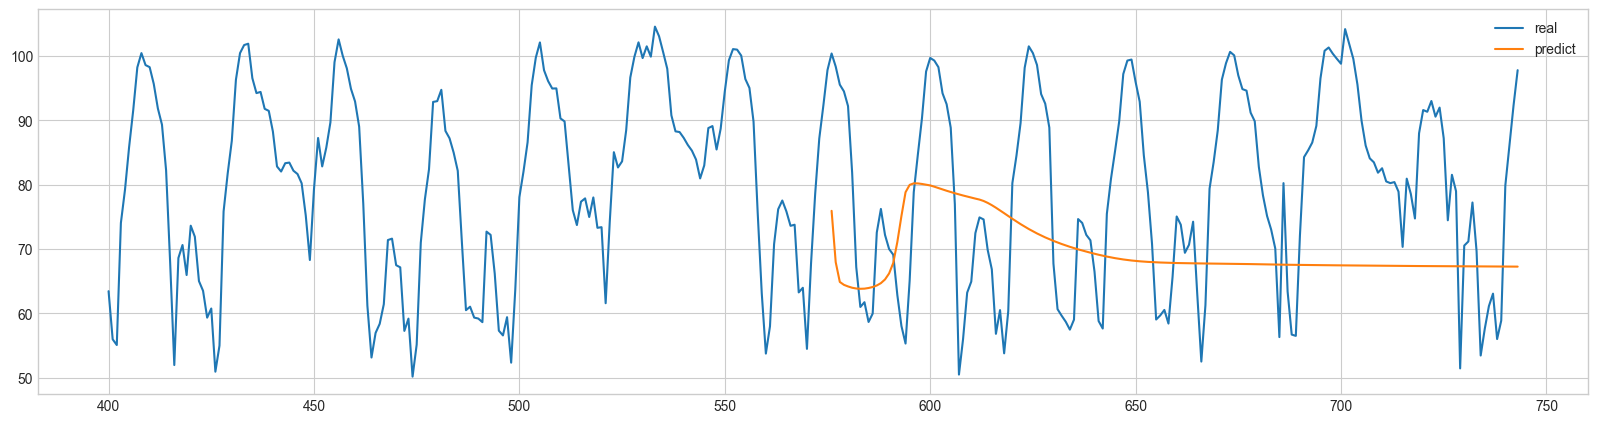

In [54]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744),real[400:], label="real")
plt.plot(range(744-24*7,744),result, label="predict")
plt.legend()
plt.show()

### Transformer Encoder, FC layer DecoderPermalink

예측해야할 step의 개수가 많기 때문에 1step씩 결과를 예측을 하는 모델로는 좋은 결과를 얻어내지 못했다.  
따라서 인코더의 아웃풋에서 FC layer를 통해 모든 결과를 한번에 예측하는 모델로 다시 시계열 예측을 시도해 보았다.  

#### Dataset

이전과 거의 동일하지만 return하는 값이 input, output 두개 뿐이라는 점이 다르다.

In [56]:
from torch.utils.data import DataLoader, Dataset

In [57]:
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        # 총 데이터의 개서
        L = y.shape[0]
        
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])
        
        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len
            

In [58]:
iw = 80
ow = 20
stride = 1

L = data_train.shape[0]
L

576

In [59]:
num_samples = (L - iw - ow)// stride + 1
num_samples

477

In [60]:
X = np.zeros([iw, num_samples])
Y = np.zeros([ow, num_samples])
print(X.shape)
print(Y.shape)

(80, 477)
(20, 477)


In [61]:
for i in np.arange(num_samples):
    start_x = stride * i
    end_x = start_x + iw
    X[:, i] = data_train[start_x : end_x]
            
    start_y = stride*i + iw
    end_y = start_y + ow
    Y[:,i] = data_train[start_y:end_y]

In [62]:
print(X.shape)
print(Y.shape)

(80, 477)
(20, 477)


In [63]:
print(X.reshape(X.shape[0], X.shape[1], 1).shape)
print(Y.reshape(Y.shape[0], X.shape[1], 1).shape)

(80, 477, 1)
(20, 477, 1)


In [68]:
X[0].shape

(477,)

In [70]:
print(X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2)).shape)
print(Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2)).shape)

(477, 80, 1)
(477, 20, 1)


데이터셋 만들기

In [71]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [75]:
print(train_dataset.x.shape)
print(train_dataset.y.shape)

(73, 336, 1)
(73, 168, 1)


### Modeling

transformer decoder를 사용하지 않고 transformer encoder의 output에 FC Layer를 연결해서 결과를 바로 예측한다.

In [77]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [78]:
def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [79]:
class TFModel(nn.Module):
    def __init__(self, iw, ow, d_model, nhead, nlayers, dropout = 0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=nlayers
            )
        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 
        
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    
    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1) #???
        output = self.linear(output)[:,:,0] ##??
        output = self.linear2(output)
        return output

다음과 같은 순서로 진행되도록 모델링 했다.   

- 1차원 벡터를 d_model 차원으로 바꿔준다.
    - (batch, input_window, 1) => (batch, input_window, d_model)

- transformer encoder를 통과한다.
    - (batch, input_window, d_model) => (batch, input_window, d_model)

- 결과의 d_model차원을 1차원으로 바꿔준다.
    - (batch, input_window, d_model) => (batch, input_window, 1)

- 1차원인 부분을 없앤다.
    - (batch, input_window, 1) => (batch, input_window)

- input_window차원을 output_window차원으로 바꿔준다.
    - (batch, input_window) => (batch, output_window)

input window의 attention의 조합으로 output window를 바로 예측할 수 있다는 가정으로 모델을 만들었다.  

linear layer들은 두 개씩 쌓아줬다.

### Training

In [80]:
torch.backends.mps.is_available()

True

In [91]:
#device = torch.device('mps')
device = 'cpu'

In [92]:
lr = 1e-4
model = TFModel(
    iw=24*7*2, 
    ow=24*7, 
    d_model=512, 
    nhead=8, 
    nlayers=4, 
    dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [93]:
model

TFModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (

In [94]:
from torchinfo import summary

In [95]:
# summary(model=model, 
#         #input_size=(64, 336, 1), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

In [96]:
epoch = 1000
model.train()
progress = tqdm(range(epoch))

for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device), src_mask)
        
        loss = criterion(result, outputs[:, :, 0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.001972: 100%|██████████| 1000/1000 [2:13:53<00:00,  8.03s/it]   


### Evaluate

학습된 모델을 이용해서 실제로 마지막 일주일의 데이터를 예측해 보았다.

In [97]:
def evaluate():
    input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

train data의 마지막 2주일의 데이터를 input으로 사용해서 그 후 일주일의 데이터를 예측하는 함수를 만들었다.

In [98]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = raw["평균속도"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]

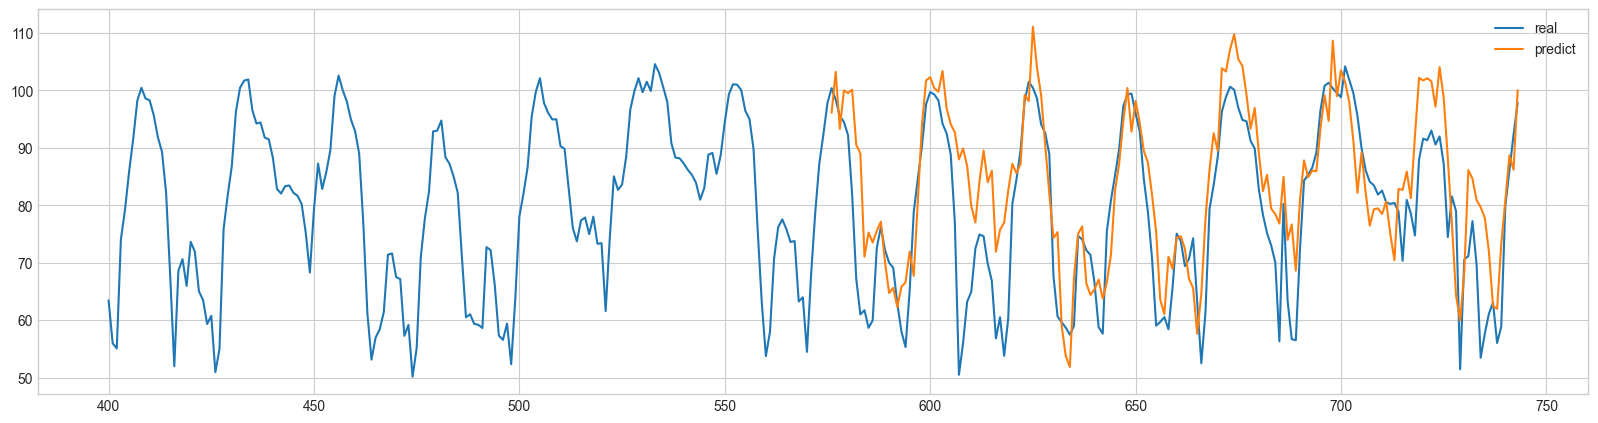

In [99]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744),real[400:], label="real")
plt.plot(range(744-24*7,744),result, label="predict")
plt.legend()
plt.show()

In [100]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

11.26400348751886

### Conclusion